# Working with Transformers in the HuggingFace Ecosystem

In this laboratory exercise we will learn how to work with the HuggingFace ecosystem to adapt models to new tasks. As you will see, much of what is required is *investigation* into the inner-workings of the HuggingFace abstractions. With a little work, a little trial-and-error, it is fairly easy to get a working adaptation pipeline up and running.

## Exercise 1: Sentiment Analysis

### 1.1

Installing Libraries

In [ ]:
!pip install datasets

Loading Dataset

In [8]:
from datasets import load_dataset
dataset_id = "rotten_tomatoes"
# Il dataset Rotten Tomatoes è disponibile con il nome "rotten_tomatoes"
dataset = load_dataset(dataset_id)

In [9]:
print(dataset)  # Dataset split: train, validation, test
# One training example
print(dataset["train"][0])

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})
{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1}


The split is 80% Train, 10% Validation, 10% Test ✅

The rock rocks 🗿

In [10]:
# Showing dataset features
print(dataset["train"].features)
# Showing instances per class (label: 0 = ❌, 1 = ✅)
from collections import Counter

labels = [example["label"] for example in dataset["train"]]
print(Counter(labels))


{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}
Counter({1: 4265, 0: 4265})


Dataset is perfectly balanced ✅

### 1.2: Pre-trained BERT
Importing Distilbert tokenizer

In [11]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
# Loading tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

Visualizing sentences length distribution

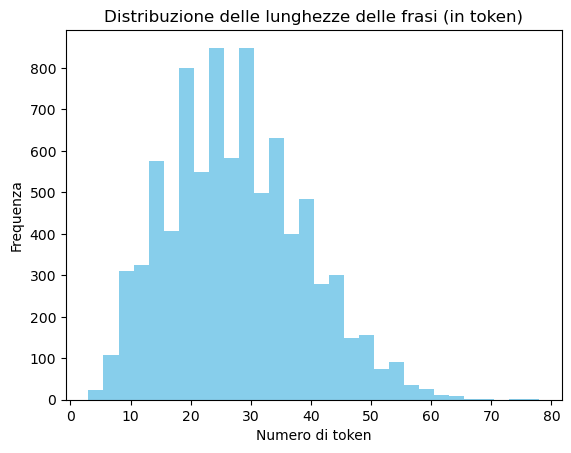

In [12]:
import matplotlib.pyplot as plt
# Calculating length (number of tokens)
lengths = [len(tokenizer(example["text"])["input_ids"]) for example in dataset["train"]]#.select(range(1000))]

# Visualizing sentences length distribution
plt.hist(lengths, bins=30, color="skyblue")
plt.title("Distribuzione delle lunghezze delle frasi (in token)")
plt.xlabel("Numero di token")
plt.ylabel("Frequenza")
plt.show()


Notes: Length of sentences varies alot

⚠️ (Optional) Installing PyTorch

In [ ]:
import subprocess
cmd = [
    "pip3", "install",
    "torch", "torchvision", "torchaudio",
    "--index-url", "https://download.pytorch.org/whl/cu118"
]
process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
for line in process.stdout:
    print(line, end='')
process.wait()

⚙️ Checking if PyTorch is correctly installed and CUDA is available

In [14]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.7.0+cu118
True


🛠️ Importing Model

In [15]:
from transformers import AutoModel
model = AutoModel.from_pretrained(model_name)

In [16]:
# Taking a couple of sentences from the dataset
sample_texts = [dataset["train"][i]["text"] for i in range(2)]

# Tokenization with padding and conversion to tensors
inputs = tokenizer(sample_texts, padding=True, truncation=True, return_tensors="pt")

print("Tokenized input keys:", inputs.keys())
print("Input IDs shape:", inputs["input_ids"].shape)


Tokenized input keys: dict_keys(['input_ids', 'attention_mask'])
Input IDs shape: torch.Size([2, 52])


In [17]:
import torch

with torch.no_grad():
    outputs = model(**inputs)

# outputs è un oggetto di tipo BaseModelOutput, contiene 'last_hidden_state'
print("Output keys:", outputs.keys())
print("Last hidden state shape:", outputs.last_hidden_state.shape)
tokenizer.decode(inputs['input_ids'][0])

Output keys: odict_keys(['last_hidden_state'])
Last hidden state shape: torch.Size([2, 52, 768])


'[CLS] the rock is destined to be the 21st century \' s new " conan " and that he \' s going to make a splash even greater than arnold schwarzenegger, jean - claud van damme or steven segal. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]'

Notes: The first token is [CLS], which codifies informations about the sentence and will be used for feature extraction

### 1.3 Stable Baseline

#### 1.3.A: Feature Extraction
We will use Distilbert to extract the features from the [CLS] token

🛠️ Definition of Extraction function:

In [18]:
import os
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader
from tqdm import tqdm

def extract_and_save_features(dataset_split, split_name, model, tokenizer, batch_size=32, save_dir="features"):
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"{split_name}_features.npz")

    if os.path.exists(save_path):
        print(f"Loading from cache: {save_path}")
        data = np.load(save_path)
        return data["features"], data["labels"]

    dataloader = DataLoader(dataset_split, batch_size=batch_size)
    all_features = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Extraction {split_name}"):
            texts = batch["text"]
            labels = batch["label"]

            inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
            outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # batch_size x hidden_size

            all_features.append(cls_embeddings)
            all_labels.extend(labels)

    features = np.concatenate(all_features)
    labels = np.array(all_labels)

    np.savez(save_path, features=features, labels=labels)
    print(f"Salvato in {save_path}")
    return features, labels



▶️ Feature Extraction

In [19]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

X_train, y_train = extract_and_save_features(dataset["train"], "train", model, tokenizer)
X_val, y_val = extract_and_save_features(dataset["validation"], "val", model, tokenizer)
X_test, y_test = extract_and_save_features(dataset["test"], "test", model, tokenizer)


Loading from cache: features\train_features.npz
Loading from cache: features\val_features.npz
Loading from cache: features\test_features.npz


#### 1.3.B: Training a Classifier

🛠️ Definition of generic evaluation function

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

def evaluate_classifier(clf, X_train, y_train, X_val, y_val, X_test, y_test, name=""):
    clf.fit(X_train, y_train)

    val_pred = clf.predict(X_val)
    test_pred = clf.predict(X_test)

    print(f"\n=== {name} ===")
    print("Validation Accuracy:", accuracy_score(y_val, val_pred))
    print("Test Accuracy:", accuracy_score(y_test, test_pred))
    print("Test Classification Report:")
    print(classification_report(y_test, test_pred, target_names=["neg", "pos"]))


▶️ Training & Evaluating with 3 classifiers: SVM, Logistic Regression, Random Forest

In [21]:
evaluate_classifier(SVC(kernel="linear"), X_train, y_train, X_val, y_val, X_test, y_test, name="SVM (Linear)")
evaluate_classifier(LogisticRegression(max_iter=1000), X_train, y_train, X_val, y_val, X_test, y_test, name="Logistic Regression")
evaluate_classifier(RandomForestClassifier(n_estimators=100), X_train, y_train, X_val, y_val, X_test, y_test, name="Random Forest")


=== SVM (Linear) ===
Validation Accuracy: 0.8189493433395872
Test Accuracy: 0.8067542213883677
Test Classification Report:
              precision    recall  f1-score   support

         neg       0.80      0.82      0.81       533
         pos       0.82      0.79      0.80       533

    accuracy                           0.81      1066
   macro avg       0.81      0.81      0.81      1066
weighted avg       0.81      0.81      0.81      1066


=== Logistic Regression ===
Validation Accuracy: 0.8302063789868668
Test Accuracy: 0.800187617260788
Test Classification Report:
              precision    recall  f1-score   support

         neg       0.79      0.81      0.80       533
         pos       0.81      0.79      0.80       533

    accuracy                           0.80      1066
   macro avg       0.80      0.80      0.80      1066
weighted avg       0.80      0.80      0.80      1066


=== Random Forest ===
Validation Accuracy: 0.7814258911819888
Test Accuracy: 0.763602251407

## Exercise 2: Fine-Tuning Distilbert
Finetuning Distilbert to improve sentiment analysis

### 2.1: Token Preprocessing
Tokenizing dataset splits to obtain token ids

🛠️ Re-loading tokenizer

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

🛠️ Defining function to tokenize a batch

In [ ]:
def tokenize_batch(batch):
    return tokenizer(batch["text"], truncation=True)#, padding="max_length")

▶️ Tokenizing splits

In [ ]:
tokenized_dataset = dataset.map(tokenize_batch, batched=True)

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

✅ Fast check

In [ ]:
tokenized_dataset["train"][0]

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
 'label': 1,
 'input_ids': [101,
  1996,
  2600,
  2003,
  16036,
  2000,
  2022,
  1996,
  7398,
  2301,
  1005,
  1055,
  2047,
  1000,
  16608,
  1000,
  1998,
  2008,
  2002,
  1005,
  1055,
  2183,
  2000,
  2191,
  1037,
  17624,
  2130,
  3618,
  2084,
  7779,
  29058,
  8625,
  13327,
  1010,
  3744,
  1011,
  18856,
  19513,
  3158,
  5477,
  4168,
  2030,
  7112,
  16562,
  2140,
  1012,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


text, label, input_ids, attention_mask are all there 👍

### 2.2 Setting up the Model

Importing model

In [ ]:
from transformers import AutoModelForSequenceClassification
model_name = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2  # sentiment analysis: Positive / Negative
)
output_dir = "./results"
final_model_folder ="./model_final"

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Defining output folders

In [ ]:
output_dir = "./results"
final_model_folder ="./model_final"

Checking model structure

In [ ]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

Checking training parameters

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

distilbert.embeddings.word_embeddings.weight
distilbert.embeddings.position_embeddings.weight
distilbert.embeddings.LayerNorm.weight
distilbert.embeddings.LayerNorm.bias
distilbert.transformer.layer.0.attention.q_lin.weight
distilbert.transformer.layer.0.attention.q_lin.bias
distilbert.transformer.layer.0.attention.k_lin.weight
distilbert.transformer.layer.0.attention.k_lin.bias
distilbert.transformer.layer.0.attention.v_lin.weight
distilbert.transformer.layer.0.attention.v_lin.bias
distilbert.transformer.layer.0.attention.out_lin.weight
distilbert.transformer.layer.0.attention.out_lin.bias
distilbert.transformer.layer.0.sa_layer_norm.weight
distilbert.transformer.layer.0.sa_layer_norm.bias
distilbert.transformer.layer.0.ffn.lin1.weight
distilbert.transformer.layer.0.ffn.lin1.bias
distilbert.transformer.layer.0.ffn.lin2.weight
distilbert.transformer.layer.0.ffn.lin2.bias
distilbert.transformer.layer.0.output_layer_norm.weight
distilbert.transformer.layer.0.output_layer_norm.bias
distil

Optional: freezing Distilbert layers

In [ ]:
for param in model.distilbert.parameters():
    param.requires_grad = False

### 2.3 Finetuning Distilbert

🛠️ Imports

In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

🛠️ Definition of function to calculate metrics

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


🛠️ Construction of DataCollatorWithPadding

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

⚙️ Training Settings

⚠️ some parameters name changes depending on `transformers` version, like eval_strategy / evaluation_strategy

In [ ]:
training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs",
)


⚙️ Trainer

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


🏋️‍♂️ Training

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
c:\Users\verba\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8530
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2136
  Number of trainable parameters = 66955010
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in a

  0%|          | 0/2136 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1066
  Batch size = 16


{'loss': 0.4137, 'learning_rate': 1.5000000000000002e-05, 'epoch': 1.0}


  0%|          | 0/67 [00:00<?, ?it/s]

Saving model checkpoint to ./results\checkpoint-534
Configuration saved in ./results\checkpoint-534\config.json


{'eval_loss': 0.34864893555641174, 'eval_accuracy': 0.8414634146341463, 'eval_precision': 0.8238434163701067, 'eval_recall': 0.8686679174484052, 'eval_f1': 0.8456621004566209, 'eval_runtime': 21.641, 'eval_samples_per_second': 49.258, 'eval_steps_per_second': 3.096, 'epoch': 1.0}


Model weights saved in ./results\checkpoint-534\pytorch_model.bin
tokenizer config file saved in ./results\checkpoint-534\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-534\special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1066
  Batch size = 16


{'loss': 0.2461, 'learning_rate': 1e-05, 'epoch': 2.0}


  0%|          | 0/67 [00:00<?, ?it/s]

Saving model checkpoint to ./results\checkpoint-1068
Configuration saved in ./results\checkpoint-1068\config.json


{'eval_loss': 0.4055609703063965, 'eval_accuracy': 0.8461538461538461, 'eval_precision': 0.8231173380035026, 'eval_recall': 0.8818011257035647, 'eval_f1': 0.8514492753623187, 'eval_runtime': 21.4523, 'eval_samples_per_second': 49.692, 'eval_steps_per_second': 3.123, 'epoch': 2.0}


Model weights saved in ./results\checkpoint-1068\pytorch_model.bin
tokenizer config file saved in ./results\checkpoint-1068\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-1068\special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1066
  Batch size = 16


{'loss': 0.1485, 'learning_rate': 5e-06, 'epoch': 3.0}


  0%|          | 0/67 [00:00<?, ?it/s]

Saving model checkpoint to ./results\checkpoint-1602
Configuration saved in ./results\checkpoint-1602\config.json


{'eval_loss': 0.514951765537262, 'eval_accuracy': 0.8414634146341463, 'eval_precision': 0.8408239700374532, 'eval_recall': 0.8424015009380863, 'eval_f1': 0.8416119962511716, 'eval_runtime': 22.3658, 'eval_samples_per_second': 47.662, 'eval_steps_per_second': 2.996, 'epoch': 3.0}


Model weights saved in ./results\checkpoint-1602\pytorch_model.bin
tokenizer config file saved in ./results\checkpoint-1602\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-1602\special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1066
  Batch size = 16


{'loss': 0.0891, 'learning_rate': 0.0, 'epoch': 4.0}


  0%|          | 0/67 [00:00<?, ?it/s]

Saving model checkpoint to ./results\checkpoint-2136
Configuration saved in ./results\checkpoint-2136\config.json


{'eval_loss': 0.6358879208564758, 'eval_accuracy': 0.8470919324577861, 'eval_precision': 0.8517110266159695, 'eval_recall': 0.8405253283302064, 'eval_f1': 0.846081208687441, 'eval_runtime': 22.5126, 'eval_samples_per_second': 47.351, 'eval_steps_per_second': 2.976, 'epoch': 4.0}


Model weights saved in ./results\checkpoint-2136\pytorch_model.bin
tokenizer config file saved in ./results\checkpoint-2136\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-2136\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results\checkpoint-1068 (score: 0.8514492753623187).


{'train_runtime': 16084.618, 'train_samples_per_second': 2.121, 'train_steps_per_second': 0.133, 'train_loss': 0.2243819593936763, 'epoch': 4.0}


TrainOutput(global_step=2136, training_loss=0.2243819593936763, metrics={'train_runtime': 16084.618, 'train_samples_per_second': 2.121, 'train_steps_per_second': 0.133, 'train_loss': 0.2243819593936763, 'epoch': 4.0})

⌛ *a few moments later* 🌸☀️🍂❄️ (4 Hours 28 minutes on Nvidia Geforce RTX 3070 Laptop)

💾 Saving model and tokenizer

In [ ]:
trainer.save_model(final_model_folder)         # Saving final model
tokenizer.save_pretrained(final_model_folder)  # Saving tokenizer

Saving model checkpoint to ./model_final
Configuration saved in ./model_final\config.json
Model weights saved in ./model_final\pytorch_model.bin
tokenizer config file saved in ./model_final\tokenizer_config.json
Special tokens file saved in ./model_final\special_tokens_map.json
tokenizer config file saved in ./model_final\tokenizer_config.json
Special tokens file saved in ./model_final\special_tokens_map.json


('./model_final\\tokenizer_config.json',
 './model_final\\special_tokens_map.json',
 './model_final\\vocab.txt',
 './model_final\\added_tokens.json',
 './model_final\\tokenizer.json')

📊 Showing results

In [ ]:
results = trainer.evaluate(tokenized_dataset["test"])
for k, v in results.items():
    print(f"{k}: {v:.4f}")

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1066
  Batch size = 16


  0%|          | 0/67 [00:00<?, ?it/s]

{'eval_loss': 0.4561544358730316, 'eval_accuracy': 0.8386491557223265, 'eval_precision': 0.8264014466546112, 'eval_recall': 0.8574108818011257, 'eval_f1': 0.841620626151013, 'eval_runtime': 21.8922, 'eval_samples_per_second': 48.693, 'eval_steps_per_second': 3.06, 'epoch': 4.0}


📊 Plot

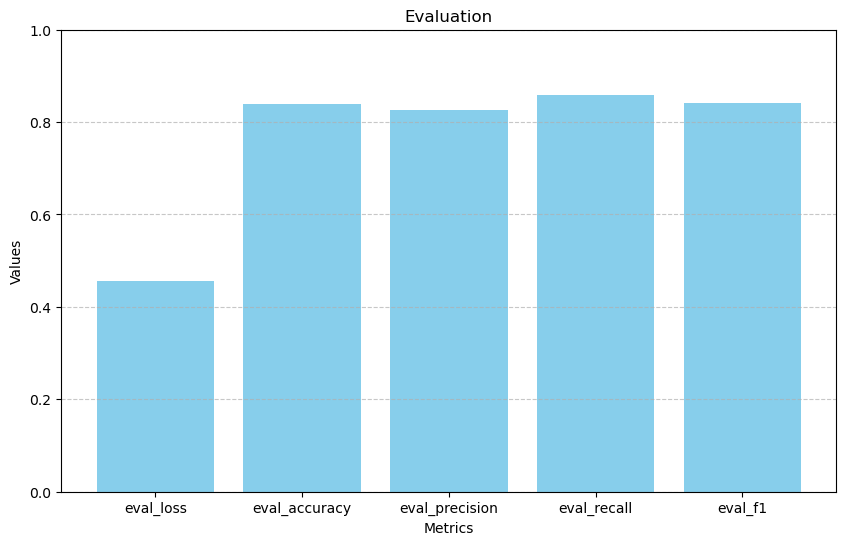

In [ ]:
metrics = list(results.keys())[:5]
values = list(results.values())[:5]
# Histogram
plt.figure(figsize=(10,6))
plt.bar(metrics, values, color='skyblue')
plt.ylim(0, 1)  # Limiti dell'asse y tra 0 e 1
plt.title('Evaluation')
plt.ylabel('Values')
plt.xlabel('Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Plot
plt.show()

(Optional) Loading model and tokenizer from file

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("./model_final")
tokenizer = AutoTokenizer.from_pretrained("./model_final")

(Optional) Training from Checkpoint

In [ ]:
checkpoint_path = "/results/checkpoint"
trainer.train(resume_from_checkpoint=checkpoint_path)

## Exercise 3

### 3.1 Efficient Finetuning for Sentiment Analysis

#### 3.1.A Finetuning of the Classifier
Freezing Distilbert parameters and training only the classifier. The only trained layers are:
```
(pre_classifier): Linear(in_features=768, out_features=768, bias=True)
(classifier): Linear(in_features=768, out_features=2, bias=True)
(dropout): Dropout(p=0.2, inplace=False)
```
Each layer inside `(distilbert): DistilBertModel( ... )` will be frozen

Re-importing the model and freezing distilbert layers:

In [ ]:
# Importing the model
from transformers import AutoModelForSequenceClassification
model_name = "distilbert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2  # sentiment analysis: Positive / Negative
)
# Freezing Distilbert layers
for param in model.distilbert.parameters():
    param.requires_grad = False
output_dir = "./results_31A"
final_model_folder ="./model_final_31A"

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


➡️ Re-Run Exercise 2.3 (or Run the code below if you don't want to ovewrite the output)

In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs",
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
trainer.train()
trainer.save_model(final_model_folder)         # Saving final model
tokenizer.save_pretrained(final_model_folder)  # Saving tokenizer
results = trainer.evaluate(tokenized_dataset["test"])
print(results)

#### 3.1.B Efficient Finetuning with LoRA


⚙️ Installing PEFT library and updating transformes library

In [ ]:
!pip install peft accelerate
#!pip install --upgrade transformers
#pip install transformers -U

Configuring the model with LoRA 

In [ ]:
from peft import get_peft_model, LoraConfig, TaskType
from transformers import AutoModelForSequenceClassification

# Loading Base model
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Configuring LoRA
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,               # rank
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_lin", "v_lin"] # Distilbert modules to be finetuned: linear layer for query and value
)

# Applying PEFT
from peft import prepare_model_for_kbit_training
model = get_peft_model(model, lora_config)

# Viewing trainable parameters
model.print_trainable_parameters()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 739,586 || all params: 67,694,596 || trainable%: 1.0925


🏋️‍♂️ Training

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./checkpoints_lora",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    logging_dir="./logs_lora",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()


C:\Users\verba\AppData\Local\Temp\ipykernel_14348\549484505.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: davidcopper (david_copper) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.530100,0.421038,0.813321,0.827451,0.791745,0.809204
2,0.419900,0.399305,0.820826,0.850410,0.778612,0.812929
3,0.410700,0.391148,0.826454,0.834615,0.814259,0.824311
4,0.401400,0.388679,0.827392,0.840156,0.808630,0.824092


TrainOutput(global_step=2136, training_loss=0.4365020387628105, metrics={'train_runtime': 90.8443, 'train_samples_per_second': 375.588, 'train_steps_per_second': 23.513, 'total_flos': 438037285337040.0, 'train_loss': 0.4365020387628105, 'epoch': 4.0})

Saving the trained model

In [ ]:
trainer.save_model("./distilbert_lora")
tokenizer.save_pretrained("./distilbert_lora")

('./distilbert_lora\\tokenizer_config.json',
 './distilbert_lora\\special_tokens_map.json',
 './distilbert_lora\\vocab.txt',
 './distilbert_lora\\added_tokens.json',
 './distilbert_lora\\tokenizer.json')

In [ ]:
results = trainer.evaluate(tokenized_dataset["test"])
for k, v in results.items():
    print(f"{k}: {v:.4f}")

eval_loss: 0.4150
eval_accuracy: 0.8133
eval_precision: 0.8151
eval_recall: 0.8105
eval_f1: 0.8128
eval_runtime: 1.0360
eval_samples_per_second: 1029.0020
eval_steps_per_second: 32.8200
epoch: 4.0000


Full Finetuning:
```
eval_loss: 0.46
eval_accuracy: 0.84
eval_precision: 0.83
eval_recall: 0.86
eval_f1: 0.84
eval_runtime: 21.89
eval_samples_per_second: 48.69
eval_steps_per_second: 3.06
epoch: 4
Time: 4 Hours 28 Minutes
```

LoRA:
```
eval_loss: 0.42
eval_accuracy: 0.81
eval_precision: 0.81
eval_recall: 0.81
eval_f1: 0.81
eval_runtime: 1.04
eval_samples_per_second: 1029.00
eval_steps_per_second: 32.82
epoch: 4
Time: 1 Minute 21 Seconds
```

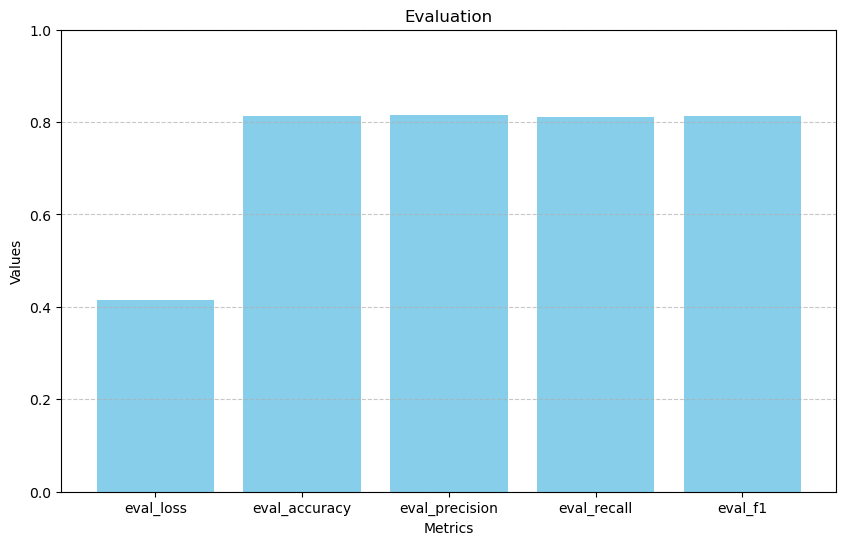

In [ ]:
from matplotlib import pyplot as plt
metrics = list(results.keys())[:5]
values = list(results.values())[:5]
# Histogram
plt.figure(figsize=(10,6))
plt.bar(metrics, values, color='skyblue')
plt.ylim(0, 1)  # Limiti dell'asse y tra 0 e 1
plt.title('Evaluation')
plt.ylabel('Values')
plt.xlabel('Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Plot
plt.show()

### 3.2 Finetuning a CLIP Model

🛠️ Functions definitions to load a CLIP model, classify an image and zero-shot evaluate

In [2]:
from transformers import CLIPProcessor, CLIPModel
from datasets import load_dataset
from PIL import Image
import torch
from tqdm import tqdm
import numpy as np

# Function to load model from model name
def load_CLIP_model(model_name):
    model = CLIPModel.from_pretrained(model_name)
    processor = CLIPProcessor.from_pretrained(model_name)
    return model, processor

# Function to classify an image with CLIP
def classify_image(image, model, processor, class_prompts):
    inputs = processor(images=image, text=class_prompts, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits = outputs.logits_per_image  # shape (1, num_classes)
    probs = logits.softmax(dim=1).squeeze()
    return torch.argmax(probs).item()

# Function to evaluate zero shot 
def zero_shot_CLIP_evaluation(dataset, model, processor, class_prompts):
    correct = 0
    total = 0

    print("⚡ Zero-shot CLIP Evaluation...")

    for sample in tqdm(dataset):
        image = sample["image"]
        true_label = sample["label"]

        pred_label = classify_image(image, model, processor, class_prompts)
        if pred_label == true_label:
            correct += 1
        total += 1

    accuracy = correct / total
    print(f"\n🎯 Zero-shot Accuracy: {accuracy:.4f}")

import matplotlib.pyplot as plt
# Function to visually show some predicted image
def show_predictions(dataset, model, processor, class_prompts, n_to_show=8):
    samples_to_show = dataset.shuffle(seed=42).select(range(n_to_show))
    fig, axs = plt.subplots(2, 4, figsize=(16, 8))
    for i, sample in enumerate(samples_to_show):
        image = sample["image"]
        true_label = sample["label"]
        pred_label = classify_image(image, processor, class_prompts)
        ax = axs[i // 4, i % 4]
        ax.imshow(image)
        ax.axis("off")
        ax.set_title(f"GT: {class_prompts[true_label]}\nPred: {class_prompts[pred_label]}", fontsize=12)
    plt.tight_layout()
    plt.show()

▶️ Loading CLIP model

In [3]:

CLIP_model_name = "openai/clip-vit-base-patch16"
CLIP_model, CLIP_processor = load_CLIP_model(CLIP_model_name)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


#### 3.2.A ImageNette

▶️ Loading ImagiNette dataset, defining class prompts

In [ ]:
# Loading subset of ImageNette
imagenette_dataset = load_dataset("frgfm/imagenette", "160px", split="validation")
imagenette_num_classes = len(set(imagenette_dataset['label']))
imagenette_dataset = imagenette_dataset.shuffle(seed=42).select(range(int(0.05 * len(imagenette_dataset))))
#dataset = imagenette_dataset.shuffle(seed=42)

# ImageNette classes (textual format for CLIP)
imagenette_class_prompts = ["a photo of a " + c for c in imagenette_dataset.features['label'].names]

Printing class count for each class, to make sure the classes aren't (too) unbalanced

In [ ]:
def count_classes(dataset, num_classes):
    class_count = [0] * num_classes
    for d in dataset:
        class_count[d['label']] += 1
    print(f"Class count: {class_count}")
count_classes(dataset=imagenette_dataset, num_classes=imagenette_num_classes)

Class count: [19, 19, 16, 21, 21, 25, 19, 24, 17, 15]


▶️ Evaluating Zero-shot the CLIP model on ImageNette

In [52]:
zero_shot_CLIP_evaluation(dataset=imagenette_dataset, model=CLIP_model, processor=CLIP_processor, class_prompts=imagenette_class_prompts)

⚡ Valutazione zero-shot CLIP su ImageNette...


100%|██████████| 196/196 [00:55<00:00,  3.52it/s]


🎯 Zero-shot Accuracy: 0.9898


It performs with ~99% Accuracy Zero-shot on ImageNette! OFC, it's pretrained on ImageNet.

📊 Showing some predictions

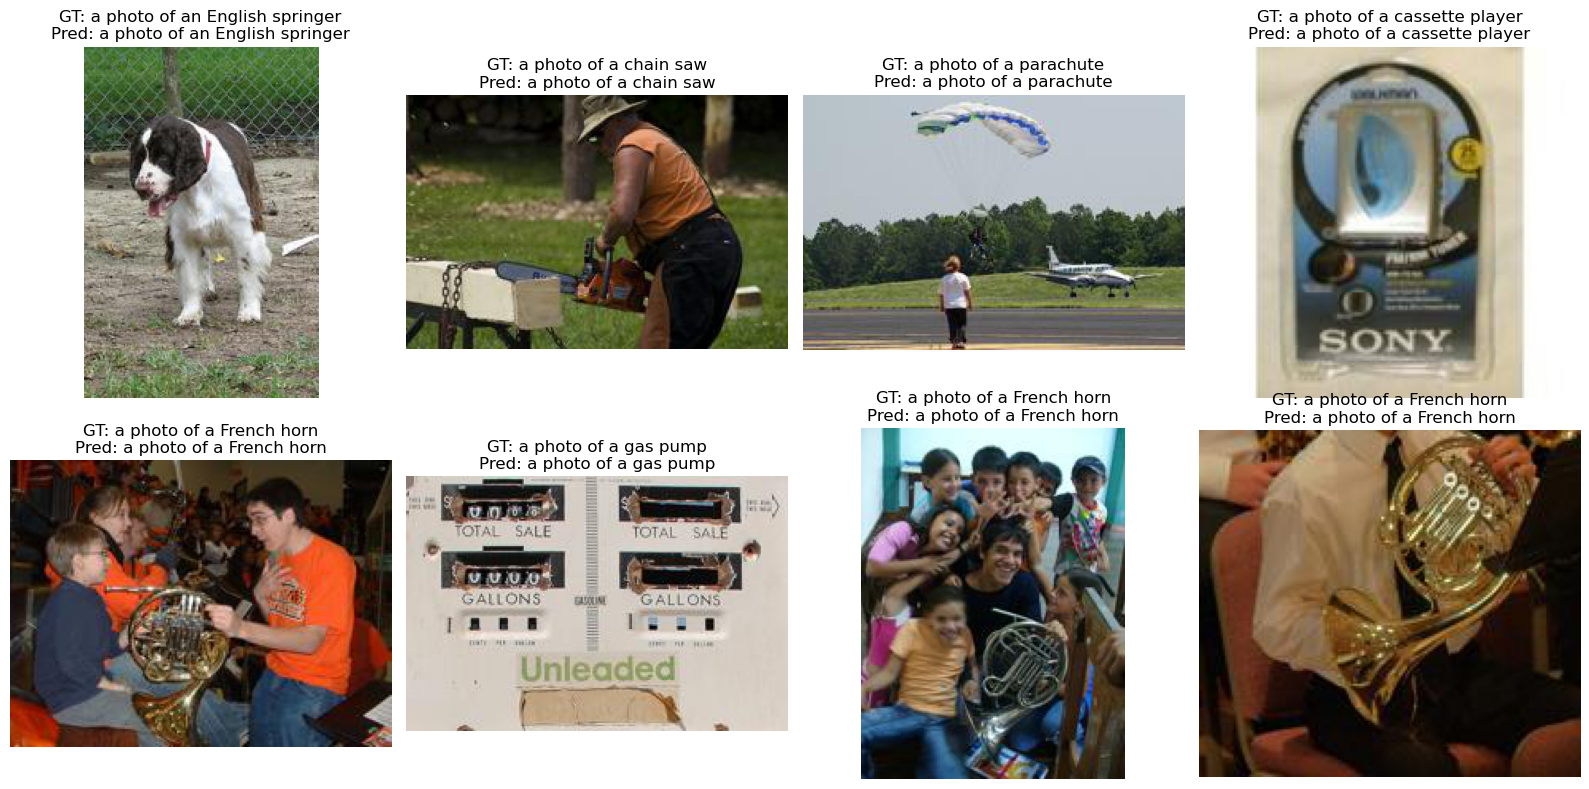

In [ ]:
show_predictions(dataset=imagenette_dataset, model=CLIP_model, processor=CLIP_processor, class_prompts=imagenette_class_prompts, n_to_show=8)

#### 3.2.B ImageNet-Sketch

▶️ Loading ImageNet-Sketch, defining class prompts

In [4]:
# Loading dataset
sketch_dataset = load_dataset("songweig/imagenet_sketch", split="train", trust_remote_code=True)
sketch_dataset_num_classes = len(set(sketch_dataset['label']))
sketch_dataset = sketch_dataset.shuffle(seed=42)
split = sketch_dataset.train_test_split(test_size=0.2, seed=42)
train_set = split["train"]
temp_set = split["test"]
val_test_split = temp_set.train_test_split(test_size=0.5, seed=42)
val_set = val_test_split["train"]
test_set = val_test_split["test"]

# Checking sizes
print(f"Train: {len(train_set)}")
print(f"Validation: {len(val_set)}")
print(f"Test: {len(test_set)}")

# Classes (textual format for CLIP)
sketch_class_prompts = ["a photo of a " + c for c in sketch_dataset.features['label'].names]

Train: 40711
Validation: 5089
Test: 5089


Checking classes names and prompts

In [61]:
print(sketch_dataset.features['label'].names)
print(sketch_class_prompts)

['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark', 'electric ray, crampfish, numbfish, torpedo', 'stingray', 'cock', 'hen', 'ostrich, Struthio camelus', 'brambling, Fringilla montifringilla', 'goldfinch, Carduelis carduelis', 'house finch, linnet, Carpodacus mexicanus', 'junco, snowbird', 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 'robin, American robin, Turdus migratorius', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel, dipper', 'kite', 'bald eagle, American eagle, Haliaeetus leucocephalus', 'vulture', 'great grey owl, great gray owl, Strix nebulosa', 'European fire salamander, Salamandra salamandra', 'common newt, Triturus vulgaris', 'eft', 'spotted salamander, Ambystoma maculatum', 'axolotl, mud puppy, Ambystoma mexicanum', 'bullfrog, Rana catesbeiana', 'tree frog, tree-frog', 'tailed frog, bell toad, 

Printing class count for each class, to make sure the classes aren't (too) unbalanced

In [65]:
def count_classes(dataset, num_classes):
    class_count = [0] * num_classes
    for d in tqdm(dataset):
        class_count[d['label']] += 1
    print(f"Class count: {class_count}")
count_classes(dataset=val_set, num_classes=sketch_dataset_num_classes)

100%|██████████| 5089/5089 [01:29<00:00, 56.84it/s]

Class count: [6, 2, 5, 4, 2, 7, 7, 4, 7, 4, 6, 4, 7, 7, 3, 6, 2, 3, 8, 4, 5, 3, 6, 1, 4, 3, 7, 10, 4, 4, 4, 1, 4, 4, 4, 8, 5, 3, 6, 5, 5, 10, 3, 3, 11, 3, 4, 6, 5, 6, 6, 7, 5, 5, 7, 6, 6, 5, 7, 3, 4, 7, 5, 6, 5, 4, 6, 5, 5, 3, 5, 6, 5, 7, 6, 4, 1, 2, 4, 2, 5, 5, 3, 2, 12, 6, 5, 4, 3, 5, 6, 6, 5, 10, 7, 8, 6, 4, 5, 6, 3, 3, 2, 4, 3, 4, 2, 6, 5, 3, 2, 8, 10, 4, 3, 4, 7, 7, 6, 5, 8, 7, 7, 7, 3, 5, 4, 8, 2, 8, 2, 4, 4, 9, 3, 5, 6, 6, 9, 2, 5, 7, 5, 2, 3, 4, 3, 6, 5, 7, 3, 4, 6, 2, 6, 1, 5, 4, 4, 7, 6, 7, 2, 7, 4, 5, 5, 3, 8, 3, 7, 4, 1, 6, 6, 5, 7, 4, 10, 2, 3, 2, 3, 4, 5, 5, 6, 5, 5, 4, 7, 5, 7, 6, 6, 7, 3, 2, 1, 4, 6, 8, 5, 2, 7, 5, 11, 8, 5, 3, 3, 7, 9, 6, 2, 7, 2, 6, 4, 3, 5, 3, 9, 3, 7, 2, 5, 4, 7, 6, 6, 5, 3, 4, 7, 5, 4, 5, 4, 4, 3, 5, 5, 5, 5, 4, 7, 6, 7, 4, 6, 4, 3, 6, 3, 6, 5, 4, 4, 2, 5, 5, 3, 1, 4, 5, 5, 3, 6, 2, 4, 5, 8, 5, 3, 3, 5, 4, 5, 2, 3, 2, 4, 1, 6, 12, 5, 4, 5, 4, 4, 5, 6, 1, 2, 6, 7, 2, 4, 3, 3, 7, 5, 6, 6, 6, 7, 6, 4, 5, 7, 8, 4, 4, 6, 2, 2, 10, 3, 4, 3, 6, 7, 2, 5, 5

In [ ]:
val_set

Dataset({
    features: ['image', 'label'],
    num_rows: 254
})

▶️ Evaluating Zero-shot the CLIP model on ImageNet-Sketch

In [7]:
val_subset = val_set.select(range(int(0.05 * len(val_set))))
zero_shot_CLIP_evaluation(dataset=val_subset, model=CLIP_model, processor=CLIP_processor, class_prompts=sketch_class_prompts)

⚡ Zero-shot CLIP Evaluation...


  0%|          | 0/254 [00:58<?, ?it/s]


KeyboardInterrupt: 

📊 Showing some predictions

In [ ]:
show_predictions(dataset=val_set, model=CLIP_model, processor=CLIP_processor, class_prompts=sketch_class_prompts, n_to_show=8)

Finetuning the model with LoRA

In [ ]:
!pip install transformers datasets peft accelerate bitsandbytes

In [ ]:
from torch.utils.data import Dataset
# Applying LoRA to the text encoder (less expensive)
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],  # Transformer modules to adapt
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.FEATURE_EXTRACTION,
)

model.text_model = get_peft_model(model.text_model, lora_config)

# Loading Training set
dataset = load_dataset("songweig/imagenet_sketch", split="train[:5000]") # remove [:5000] to download full train set
imagenet_labels = dataset.features["label"].names

# Preprocessing: encode immagini + etichette
class CLIPDataset(Dataset):
    def __init__(self, dataset, processor, label_texts):
        self.dataset = dataset
        self.processor = processor
        self.label_texts = label_texts

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample["image"]
        label = sample["label"]

        # Prepara input immagine + tutti i prompt delle classi
        inputs = self.processor(
            text=[self.label_texts[label]],
            images=image,
            return_tensors="pt",
            padding=True,
            truncation=True
        )
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["labels"] = torch.tensor(label)
        return inputs

train_dataset = CLIPDataset(dataset, CLIP_processor, imagenet_labels)

# 5. Training settings
training_args = TrainingArguments(
    output_dir="./clip-lora-sketch",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    learning_rate=5e-5,
    logging_steps=50,
    save_strategy="epoch",
    remove_unused_columns=False,
    report_to="none",
)

# 6. Funzione di valutazione
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.tensor(logits).argmax(dim=-1)
    acc = (preds == torch.tensor(labels)).float().mean()
    return {"accuracy": acc.item()}

# 7. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics,
)

# 8. Train!
trainer.train()
